## TransNetV2

In [ ]:
import sys, os
from pathlib import Path
sys.path.append(str(Path('impl.ipynb').resolve().parents[3]))
from prep.params import SQLITE_PATH
from prep.sqlitedb import MetadataDB
from prep.base import DataDirectory, Video

In [2]:
db = MetadataDB("../../"+SQLITE_PATH)
if db.check_table_exists("Video"):
    video_ids = [video[0] for video in db.fetch_videos()]
    print(f"There are {len(video_ids)} videos in the database, ids as below:")
    print(video_ids)

Tables 'Video' created or already exist.
There are 3 videos in the database, ids as below:
['07187f01-642c-49ed-9b23-e0aec49fb9b4', 'b372dd52-027d-47d1-8c08-d4fb38f8230d', 'b6a50236-bed1-4e87-9779-47a37138bbd7']


In [ ]:
from data.models.TransNetV2.inference.transnetv2 import TransNetV2
model = TransNetV2()

video_path = "../../"+db.fetch_video_by_id(video_ids[0])[1]
video_frames, single_frame_predictions, all_frame_predictions = model.predict_video(video_path)
print(f"Video frames shape: {video_frames.shape}")

[TransNetV2] Using weights from /Users/dna-tuananguyen/Downloads/Exploring/HCMAI25/PixeFlow/data/models/TransNetV2/inference/transnetv2-weights/.
[TransNetV2] Extracting frames from ../../../data/sample/vtv24-1.mp4
[TransNetV2] Processing video frames 2754/2754
Video frames shape: (2754, 27, 48, 3)


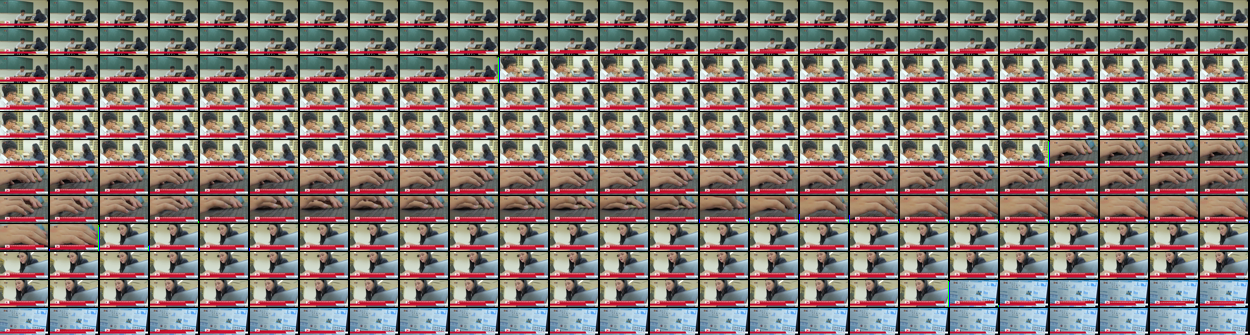

In [9]:
model.visualize_predictions(video_frames[:300], predictions=(single_frame_predictions[:300], all_frame_predictions[:300]))

### Question<br>
Where should the extracted frames inside a scene?<br> 
- [start, mid, end] or
- [start+10%, end-10%]

### Convert Image to Base64

In [12]:
import cv2
import base64
from io import BytesIO
from PIL import Image

def extract_raw_frames_base64(video_path, scenes):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    result = {}

    for idx, (start, end) in enumerate(scenes):
        mid = (start + end) // 2
        frame_indices = [start, mid, end]
        labels = ['start', 'mid', 'end']

        scene_data = {}

        for label, frame_idx in zip(labels, frame_indices):
            if frame_idx >= total_frames:
                continue

            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                continue

            # Convert BGR (OpenCV) to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Convert to PIL Image
            image = Image.fromarray(frame_rgb)

            # Save to in-memory buffer
            buffered = BytesIO()
            image.save(buffered, format="JPEG")

            # Encode to base64
            img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
            scene_data[label] = img_str

        result[idx] = scene_data

    cap.release()
    return result

scenes = model.predictions_to_scenes(single_frame_predictions)
base64_frames = extract_raw_frames_base64(video_path, scenes)

### Display in HTML


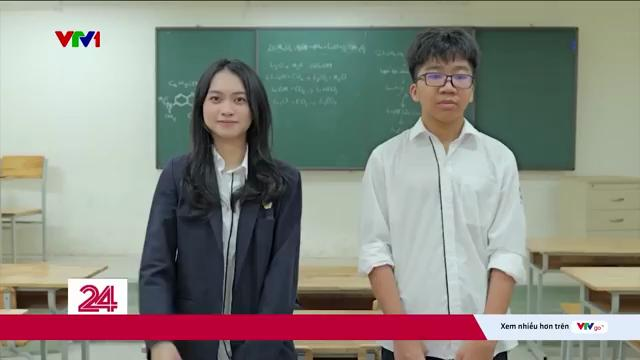

In [13]:
# To display in HTML or a notebook:
from IPython.display import HTML
scene_0_start_img = base64_frames[12]['start']
HTML(f'<img src="data:image/jpeg;base64,{scene_0_start_img}" width="640"/>')


### Packed

In [3]:
from prep.imageProcessing.FrameDetection.FrameDetect import FrameExtractor

video_id = video_ids[0]
video_path = "../../"+db.fetch_video_by_id(video_ids[0])[1]

FrameExtr = FrameExtractor(video_path, video_id)
FrameExtr.get_frames()
for frame in FrameExtr.frames[:10]:
    print(f"Video ID: {frame.video_id}, Timestamp: {frame.timestamp}, Base64 Length: {len(frame.bs64)}")

[TransNetV2] Using weights from /Users/dna-tuananguyen/Downloads/Exploring/HCMAI25/PixeFlow/data/models/TransNetV2/inference/transnetv2-weights/.
[TransNetV2] Extracting frames from ../../../data/sample/vtv24-1.mp4
[TransNetV2] Processing video frames 2754/2754
Video ID: 07187f01-642c-49ed-9b23-e0aec49fb9b4, Timestamp: 0.48, Base64 Length: 33160
Video ID: 07187f01-642c-49ed-9b23-e0aec49fb9b4, Timestamp: 1.92, Base64 Length: 34204
Video ID: 07187f01-642c-49ed-9b23-e0aec49fb9b4, Timestamp: 3.08, Base64 Length: 42084
Video ID: 07187f01-642c-49ed-9b23-e0aec49fb9b4, Timestamp: 5.12, Base64 Length: 43140
Video ID: 07187f01-642c-49ed-9b23-e0aec49fb9b4, Timestamp: 6.28, Base64 Length: 31528
Video ID: 07187f01-642c-49ed-9b23-e0aec49fb9b4, Timestamp: 7.6, Base64 Length: 29632
Video ID: 07187f01-642c-49ed-9b23-e0aec49fb9b4, Timestamp: 8.64, Base64 Length: 31600
Video ID: 07187f01-642c-49ed-9b23-e0aec49fb9b4, Timestamp: 10.2, Base64 Length: 31956
Video ID: 07187f01-642c-49ed-9b23-e0aec49fb9b4, Tim

In [4]:
frame = FrameExtr.frames[44]

print(frame.id)
print(frame.video_id)
print(frame.timestamp)
print(frame.bs64[:30])  # first 30 characters


07163f44-bc57-457c-8aa7-6a946e062a7f
07187f01-642c-49ed-9b23-e0aec49fb9b4
55.92
/9j/4AAQSkZJRgABAQAAAQABAAD/2w



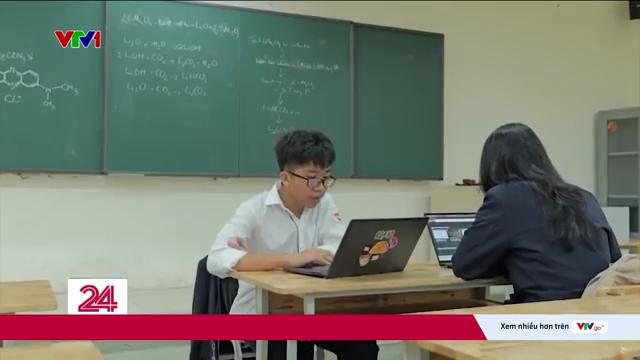


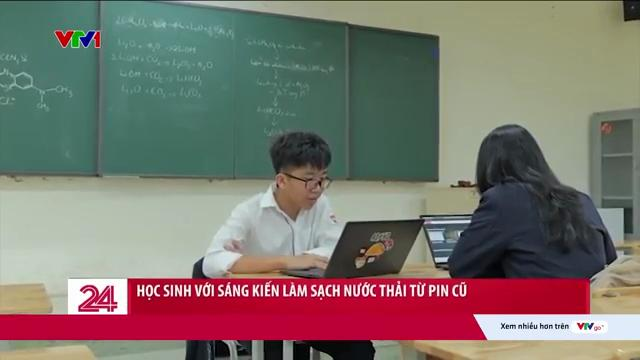


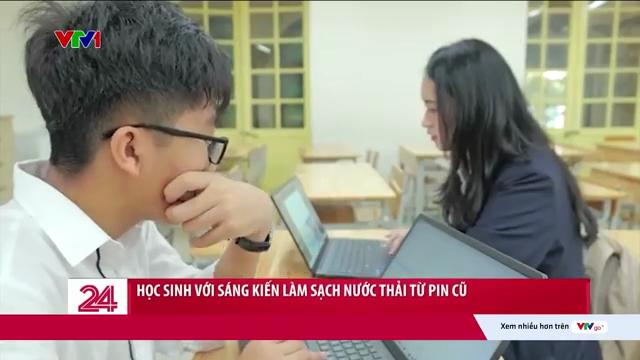


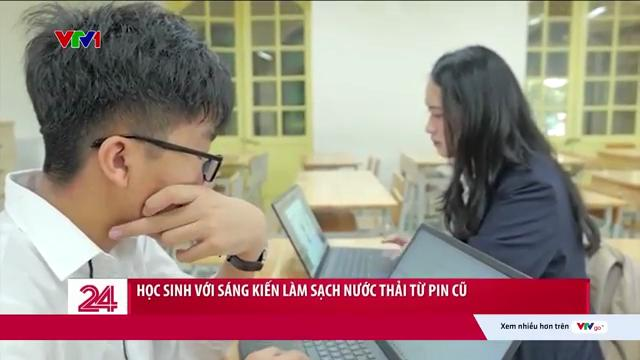


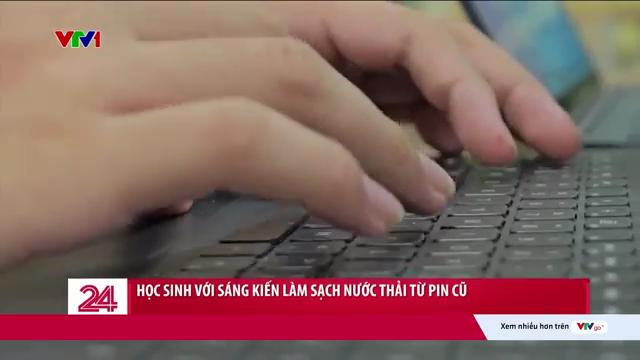

In [5]:
def vizualize_frame(bs64):
    from IPython.display import HTML
    return HTML(f'<img src="data:image/jpeg;base64,{bs64}" width="640"/>')

for frame in FrameExtr.frames[:5]:
    display(vizualize_frame(frame.bs64))